# Lightgbm-demo

## 라이브러리 import 및 설정

In [73]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error # accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [75]:
rcParams['figure.figsize'] = (12, 6)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [76]:
data_dir = Path('C:\DACON\seoul-bicycle\dataset')
sub_dir = Path('C:\DACON\seoul-bicycle\/build')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'submission.csv'

target_col = 'count'
seed = 12

In [77]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

# feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'
print(sub_file)

C:\DACON\seoul-bicycle\build\lgbcv_feature.csv


In [78]:
trn = pd.read_csv(trn_file, index_col=0)
tst = pd.read_csv(tst_file, index_col=0)

# 앞의 값으로 결측치 채우기
trn = trn.fillna(method='ffill')
tst = tst.fillna(method='ffill')

print(trn.shape, tst.shape)
trn.head()

(1459, 10) (715, 9)


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,,,,,,,,,,
3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [79]:
y = trn[target_col]
trn.drop(target_col, axis=1, inplace=True)
feature_name = trn.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(1459,) (1459, 9) (715, 9)


## 학습/검증 데이터 구분 (skip)

In [80]:
# X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
# print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

## Stratified K-Fold Cross Validation

In [81]:
n_fold = 5
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [82]:
cv

StratifiedKFold(n_splits=5, random_state=12, shuffle=True)

## LightGBM 모델 학습

In [83]:
trn.iloc[1, :]

hour                       13.000
hour_bef_temperature       20.100
hour_bef_precipitation      0.000
hour_bef_windspeed          1.400
hour_bef_humidity          48.000
hour_bef_visibility       916.000
hour_bef_ozone              0.042
hour_bef_pm10              73.000
hour_bef_pm2.5             40.000
Name: 6, dtype: float64

In [84]:
# clf = lgb.LGBMRegressor(n_estimators=1000,
#                          num_leaves=64,
#                          learning_rate=0.1,
#                          min_child_samples=10,
#                          subsample=.5,
#                          subsample_freq=1,
#                          colsample_bytree=.8,
#                          random_state=seed,
#                          n_jobs=-1)
# clf.fit(X_trn, y_trn,
#         eval_set=[(X_val, y_val)],
#         eval_metric='rmse',
#         early_stopping_rounds=10)
# p_val = clf.predict(X_val)
# p_tst = clf.predict(tst)

In [85]:
p_val = np.zeros(trn.shape[0])
p_tst = np.zeros((tst.shape[0], n_fold))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'>> cv train #{i}')
    clf = lgb.LGBMRegressor(n_estimators=1000,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
    clf.fit(trn.iloc[i_trn], y.iloc[i_trn],
        eval_set=[(trn.iloc[i_val], y.iloc[i_val])],
        eval_metric='rmse',
        early_stopping_rounds=10)
    
    p_val[i_val] = clf.predict(trn.iloc[i_val])
    p_tst[:, i-1] = clf.predict(tst)


>> cv train #1
[1]	valid_0's rmse: 79.3786	valid_0's l2: 6300.96
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 73.9154	valid_0's l2: 5463.48
[3]	valid_0's rmse: 69.1026	valid_0's l2: 4775.17
[4]	valid_0's rmse: 64.7486	valid_0's l2: 4192.38
[5]	valid_0's rmse: 61.9214	valid_0's l2: 3834.26
[6]	valid_0's rmse: 58.365	valid_0's l2: 3406.48
[7]	valid_0's rmse: 56.4958	valid_0's l2: 3191.78
[8]	valid_0's rmse: 53.6953	valid_0's l2: 2883.19
[9]	valid_0's rmse: 51.4657	valid_0's l2: 2648.72
[10]	valid_0's rmse: 49.4414	valid_0's l2: 2444.46
[11]	valid_0's rmse: 47.5897	valid_0's l2: 2264.78
[12]	valid_0's rmse: 46.7775	valid_0's l2: 2188.14
[13]	valid_0's rmse: 45.9096	valid_0's l2: 2107.69
[14]	valid_0's rmse: 44.5908	valid_0's l2: 1988.34
[15]	valid_0's rmse: 43.4381	valid_0's l2: 1886.87
[16]	valid_0's rmse: 43.0992	valid_0's l2: 1857.54
[17]	valid_0's rmse: 42.3095	valid_0's l2: 1790.09
[18]	valid_0's rmse: 41.4845	valid_0's l2: 1720.96
[19]	valid_0's r

No handles with labels found to put in legend.


p: 63 	y: 49.0
p: 158 	y: 159.0
p: 25 	y: 26.0
p: 84 	y: 57.0
p: 320 	y: 431.0
p: 32 	y: 39.0
p: 22 	y: 23.0
p: 140 	y: 146.0
p: 74 	y: 39.0
p: 93 	y: 83.0


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  2.,  2.,  2.,  4.,  4.,  2., 15.,  9., 11., 26.,
        25., 26., 15.,  8.,  7.,  4.,  9.,  7.,  4.,  2.,  1.,  1.,  3.,
         0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-170. , -163.6, -157.2, -150.8, -144.4, -138. , -131.6, -125.2,
        -118.8, -112.4, -106. ,  -99.6,  -93.2,  -86.8,  -80.4,  -74. ,
         -67.6,  -61.2,  -54.8,  -48.4,  -42. ,  -35.6,  -29.2,  -22.8,
         -16.4,  -10. ,   -3.6,    2.8,    9.2,   15.6,   22. ,   28.4,
          34.8,   41.2,   47.6,   54. ,   60.4,   66.8,   73.2,   79.6,
          86. ,   92.4,   98.8,  105.2,  111.6,  118. ,  124.4,  130.8,
         137.2,  143.6,  150. ]),
 <BarContainer object of 50 artists>)

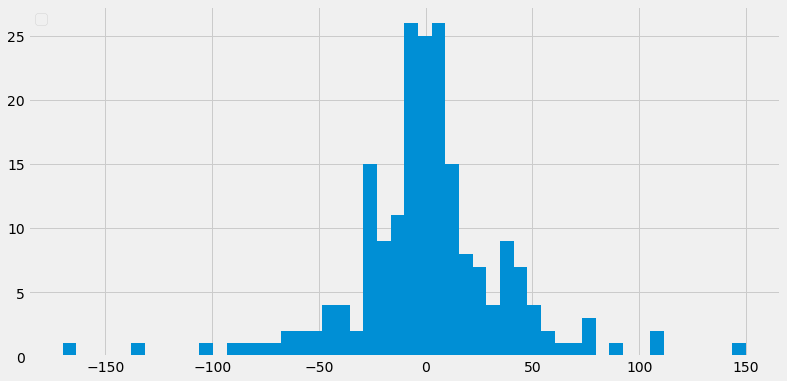

In [86]:
for i in range(10):
    print("p:", round(p_val[i]), "\ty:", y.iloc[i])

# plt.scatter(range(200), p_val[:200].astype(int), label='pred')
# plt.scatter(range(200), y.iloc[:200], label='truth')
# plt.scatter(range(200), y.iloc[:200]-p_val[:200].astype(int), label='diff')
plt.legend(loc='upper left')

plt.hist(y.iloc[:200]-p_val[:200].astype(int), bins=50)

In [87]:
print('mse:', f'{mean_squared_error(y, p_val):.4f}')

mse: 1522.7359


In [88]:
p_tst = np.median(p_tst, axis=1).astype(int)

## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

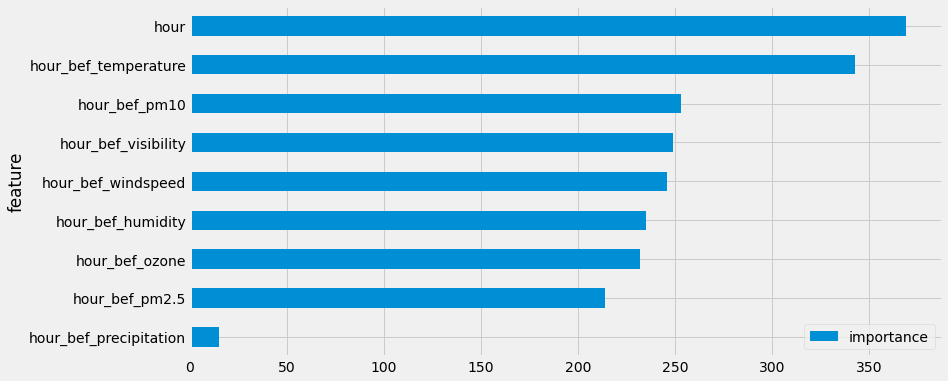

In [89]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [90]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(715, 1)


,count
id,
0,NaN
1,NaN
2,NaN
4,NaN
5,NaN


In [91]:
sub[target_col] = p_tst
sub.head()

,count
id,
0,103
1,197
2,64
4,50
5,44


In [92]:
sub[target_col].value_counts()

35     14
37      8
99      7
104     7
76      6
       ..
252     1
327     1
332     1
273     1
284     1
Name: count, Length: 264, dtype: int64

In [93]:
sub.to_csv(sub_file)